In [91]:
from rp import *
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

In [43]:
num_images=1000
image_folder='data/celeba/img_align_celeba'
images=load_images(random_batch(get_all_paths(image_folder),num_images),strict=False)
images=[as_rgb_image(as_float_image(image)) for image in images,]
images=as_numpy_array(images)

In [105]:
def scatter_plot(coordinates,*,ylabel='Y',xlabel='X',title=''):
    x,y=zip(*coordinates)
    sns.lmplot(x=xlabel,y=ylabel,data=pd.DataFrame({xlabel:x,ylabel:y}),scatter_kws={"alpha":.5,'s':4},line_kws={'color': 'red','alpha':.5})
    plt.title(title)

In [101]:
def pearson_correlation(coordinates):
    #Coordinates is a list of 2d float tuples
    return scipy.stats.pearsonr(*zip(*coordinates))[0] 

Target Images



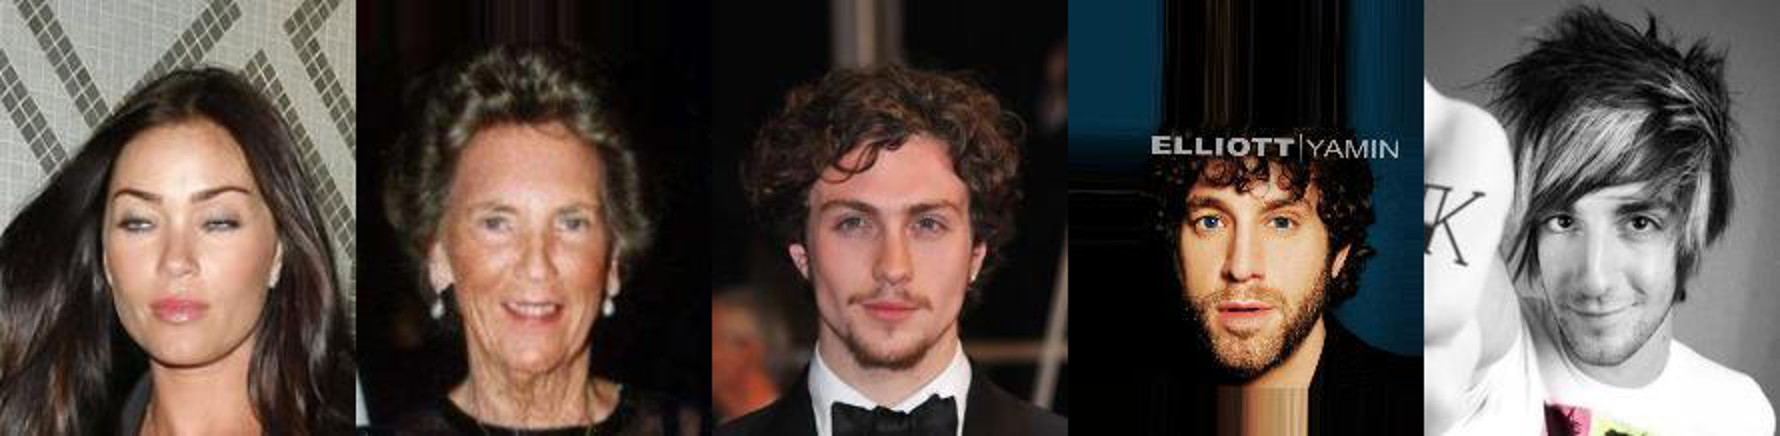

In [38]:
#Show some examples of our images
example_image_indices=random_batch(range(len(images)),5)
print("Target Images")
display_image(horizontally_concatenated_images(images[example_image_indices]))

In [111]:
number_of_points=1000
distance_index_pairs=[(random_index(images),random_index(images)) for _ in range(number_of_points)]

def get_distance_pairs(input_images,target_images=images,distance_index_pairs=distance_index_pairs):
    distance_pairs=[(euclidean_distance(input_images [from_index],input_images [to_index]),
                     euclidean_distance(target_images[from_index],target_images[to_index]))
                   for from_index,to_index in distance_index_pairs]
    return distance_pairs

def get_centered_distance_pairs(input_images,target_images=images,distance_index_pairs=distance_index_pairs):
    #This is just like get_distance_pairs, except that we subtract the mean from every input image
    #This is what we do before PCA, so when trying to predict how successful orthogonal transformations are,
    #It makes sense to subtract the means of the images we're evaluating orthogonality for.
    #In the original author's paper, they did not do this, and used the equivalent of the get_distance_pairs function.
    distance_pairs=[(euclidean_distance(input_images [from_index]-input_images [from_index].mean(0).mean(0),input_images [to_index]-input_images [to_index].mean(0).mean(0)),
                     euclidean_distance(target_images[from_index]-target_images[from_index].mean(0).mean(0),target_images[to_index]-target_images[to_index].mean(0).mean(0)))
                   for from_index,to_index in distance_index_pairs]
    return distance_pairs

Grayscale Images



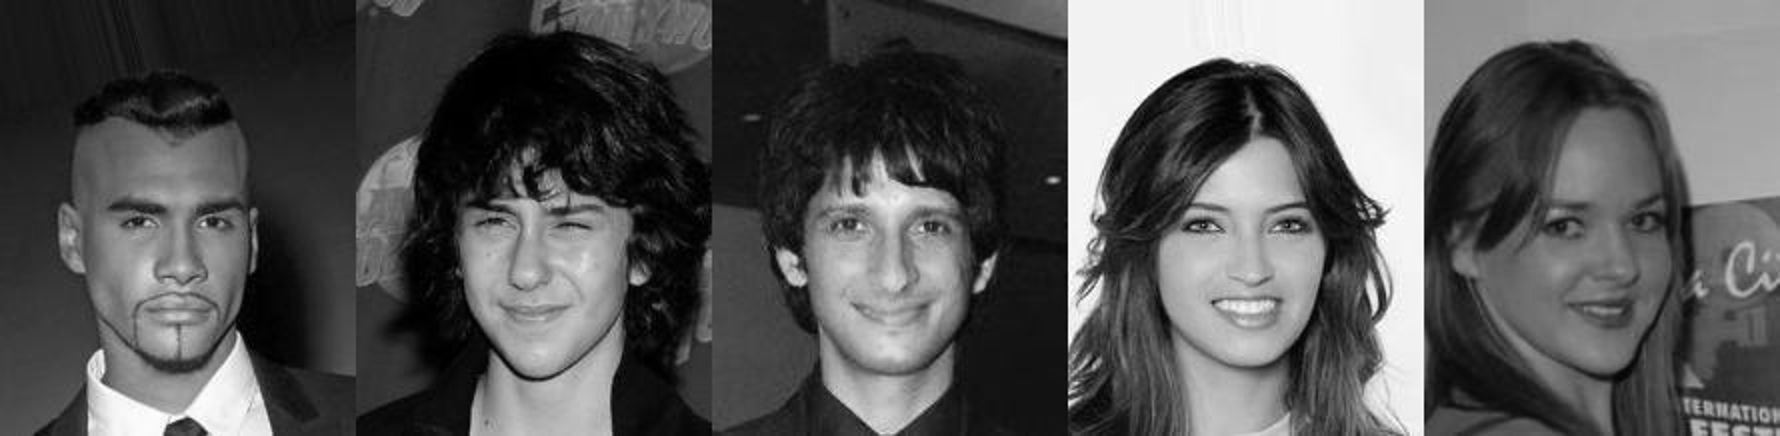

In [113]:
grayscale_images=as_numpy_array([as_rgb_image(as_grayscale_image(image)) for image in images])
print("Grayscale Images")
display_image(horizontally_concatenated_images(grayscale_images[example_image_indices]))

grayscale_distance_pairs=get_distance_pairs(grayscale_images)

Pearson Correlation = 0.99180


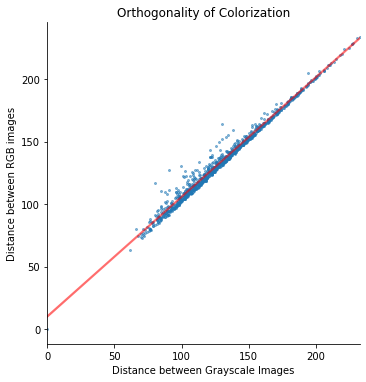

In [114]:
scatter_plot(grayscale_distance_pairs,title='Respective Distances of Colorization',xlabel='Distance between Grayscale Images',ylabel='Distance between RGB images')
print('Pearson Correlation = %.5f'%pearson_correlation(grayscale_distance_pairs))


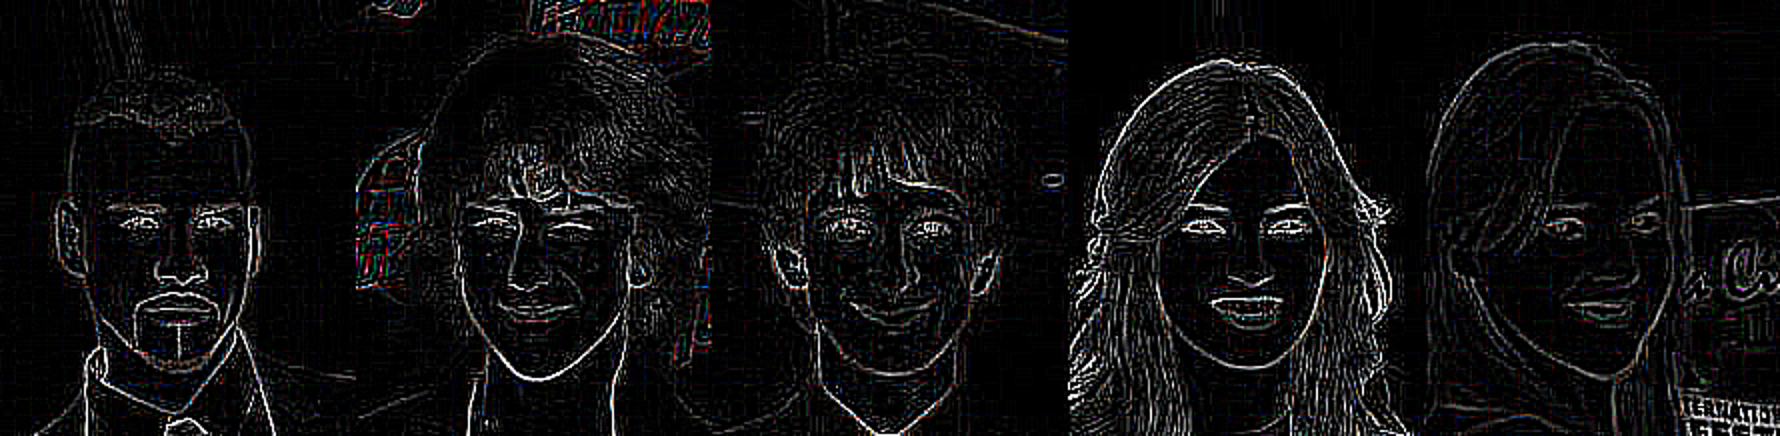

Pearson Correlation = 0.20954


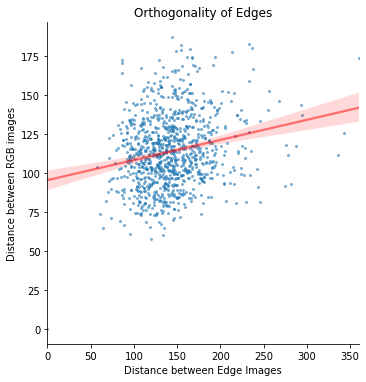

In [115]:
def laplacian_filter(image,ksize=3):
    return cv2.Laplacian(image.astype(np.float32), cv2.CV_32F, ksize=ksize)

edge_images=as_numpy_array([laplacian_filter(image) for image in images])
display_image(horizontally_concatenated_images(edge_images[example_image_indices]))

edge_distance_pairs=get_centered_distance_pairs(edge_images)
scatter_plot(edge_distance_pairs,title='Respective Distances of Edges',xlabel='Distance between Edge Images',ylabel='Distance between RGB images')
print('Pearson Correlation = %.5f'%pearson_correlation(edge_distance_pairs))

This is my explanation of why the Edges2Real example they showed in their paper was nowhere near as good as the image colorization task. The orthogonal transformation isn't nearly as good: you can tell, because distances from the source images don't correlate well to the distances of their respective target images. 

In [171]:
patch_size=10 #Square patch size in pixels

def get_patches(images,patch_size=patch_size):
    return split_tensor_into_regions(images,len(images),images.shape[1]//patch_size,images.shape[2]//patch_size).squeeze()

image_patches=get_patches(images)

Target Patches



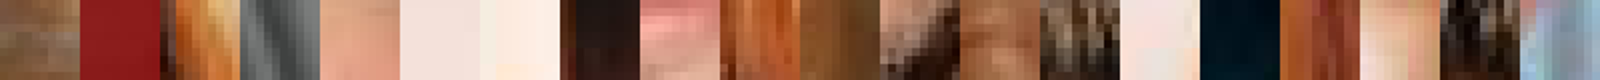

In [117]:
#Show some examples of our image patches
example_image_patch_indices=random_batch(range(len(images)),20)
print("Target Patches")
display_image(resize_image(horizontally_concatenated_images(image_patches[example_image_patch_indices]),4,interp='nearest'))

Edges Patches



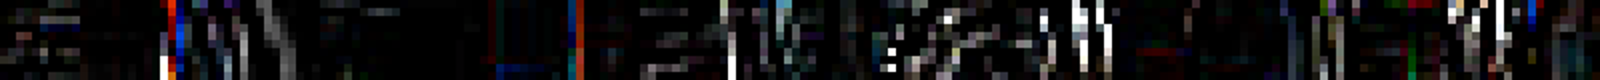

In [122]:
#Show some examples of our image patches
edge_image_patches=get_patches(edge_images)
print("Edges Patches")
display_image(resize_image(horizontally_concatenated_images(edge_image_patches[example_image_patch_indices]),4,interp='nearest'))

Pearson Correlation = 0.68627


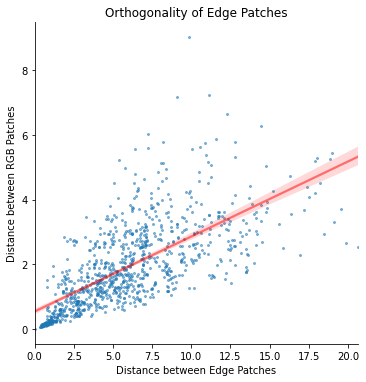

In [123]:
edge_patch_distance_pairs=get_centered_distance_pairs(edge_image_patches,image_patches)
scatter_plot(edge_patch_distance_pairs,title='Respective Distances of Edge Patches',xlabel='Distance between Edge Patches',ylabel='Distance between RGB Patches')
print('Pearson Correlation = %.5f'%pearson_correlation(edge_patch_distance_pairs))

As you can see, when we use smaller patches (instead of entire images), the correlation between corresponding distances shoots up dramatically. Because the distances are better preserved when using small patches of the image, this suggests that small image patches more suitable for an orthogonal transformation than using the entire image all at once.

Therefore, my hypothesis is that, at least for the edges-to-real task, we'll get more realistic results when transforming small image patches than we will if we transform the entire image at once (as they did in their paper).

In [126]:
import cyclegan.ryan_gender_bender as bender

Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
------------Number of Parameters---------------
[Network Gab] Total number of parameters : 11.378 M
[Network Gba] Total number of parameters : 11.378 M
[Network Da] Total number of parameters : 2.765 M
[Network Db] Total number of parameters : 2.765 M
-----------------------------------------------


/home/ryan/CleanCode/SBU/Classes/CSE527_Computer_Vision/Project/cyclegan/arch/ops.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, gain)
/home/ryan/CleanCode/SBU/Classes/CSE527_Computer_Vision/Project/cyclegan/arch/ops.py:21: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


 [*] Loading checkpoint from ./checkpoints/horse2zebra/latest.ckpt succeed!


Boys:



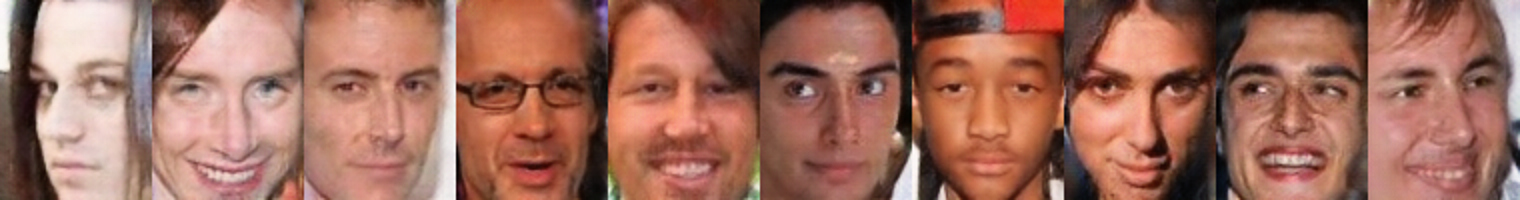

Girls:



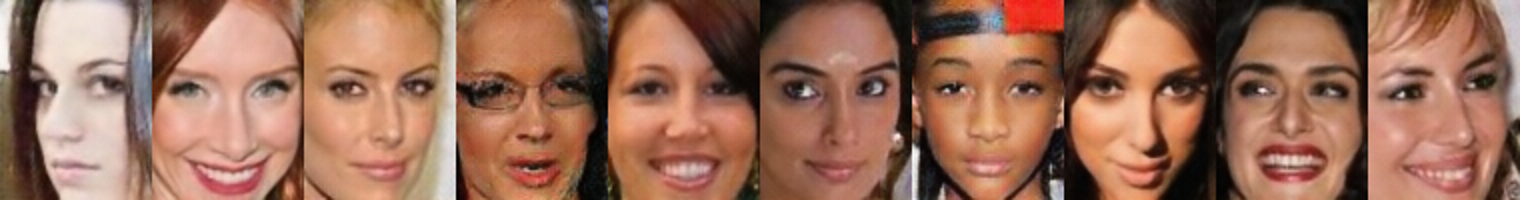

In [162]:
import cyclegan.ryan_gender_bender as bender
cropped_images=[crop_image(image[20:],width=178*.5,height=218*.5,origin='center') for image in images]

boys =as_numpy_array([bender.masculinize(image) for image in cropped_images]) #Whether or not it's a boy, we're going to apply CycleGan to it anyway in this example
girls=as_numpy_array([bender.feminize   (image) for image in cropped_images])

example_gender_indices=random_batch(range(len(cropped_images)),10)

print("Boys:")
display_image(horizontally_concatenated_images(boys [example_gender_indices]))
print("Girls:")
display_image(horizontally_concatenated_images(girls[example_gender_indices]))


Pearson Correlation = 0.97502


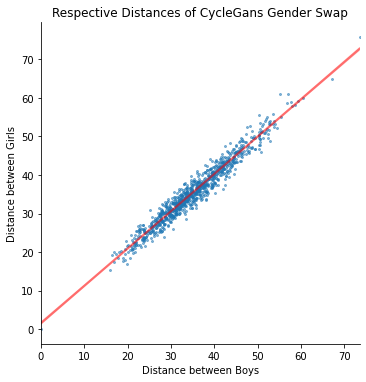

In [166]:
gender_distance_pairs=get_centered_distance_pairs(boys,girls)
scatter_plot(gender_distance_pairs,title='Respective Distances of CycleGans Gender Swap',xlabel='Distance between Boys',ylabel='Distance between Girls')
print('Pearson Correlation = %.5f'%pearson_correlation(gender_distance_pairs))

Boy Patches



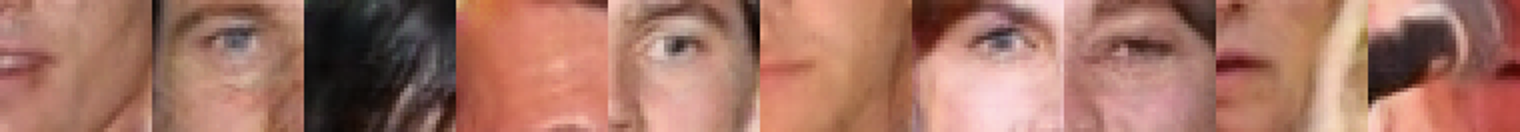

Girl Patches



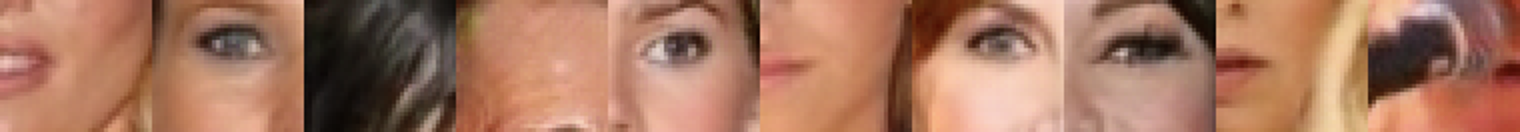

In [177]:
boy_patches =get_patches(boys ,30)
girl_patches=get_patches(girls,30)

#Show some examples of our image patches
print("Boy Patches")
display_image(resize_image(horizontally_concatenated_images(boy_patches [example_image_patch_indices[:10]]),2,interp='nearest'))

print("Girl Patches")
display_image(resize_image(horizontally_concatenated_images(girl_patches[example_image_patch_indices[:10]]),2,interp='nearest'))

Pearson Correlation = 0.95272


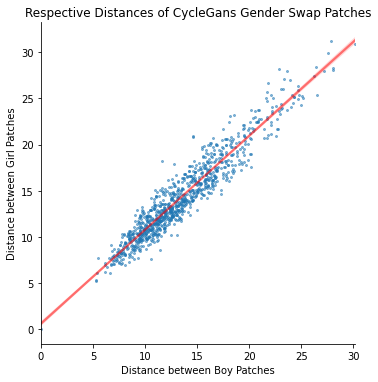

In [176]:
gender_patch_distance_pairs=get_centered_distance_pairs(boy_patches,girl_patches)
scatter_plot(gender_patch_distance_pairs,title='Respective Distances of CycleGans Gender Swap Patches',xlabel='Distance between Boy Patches',ylabel='Distance between Girl Patches')
print('Pearson Correlation = %.5f'%pearson_correlation(gender_patch_distance_pairs))

Apparently, breaking images into patches doesn't always make the correlation go up. In the case of gender swapping on faces, it actually made it slightly worse.